# Summary

## Implementation of The 10-armed Testbed using *Optimistic Initial Values* technique discussed in section 2.6 of Sutton & Barto book [1]
- Shows the performance on the 10-armed bandit testbed for two setups:
    - Greedy method with Q1(a) = +5, for all a. 
    - epsilon-Greedy method with Q1(a) = +0, for all a (epsilon=0.1).
- For both problems a constant-alpha method for action-value estimation (alpha=0.1).

[1] Sutton, R. S. & Barto, A. G. (2018), Reinforcement Learning: An Introduction, The MIT Press.

In [1]:
#Import statements
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [2]:
def plot_results(returns):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
    # Plotting average reward per time step    
    for k, v in returns.items():
        y = np.mean(v['R'], axis=0)
        x = np.arange(0, len(y))
        ax[0,0].plot(x, y, label=k)

    ax[0,0].set(title='Rewards',
           ylabel='Average Reward',
           xlabel='')
    ax[0,0].legend(loc='lower right') 

    # Plotting % optimal actions taken when in time-step t
    for k, v in returns.items():
        y = np.sum(v['opt_A'], axis=0)/total_runs
        x = np.arange(0, len(y))
        ax[0,1].plot(x, y, label=k)

    ax[0,1].set(title='Actions',
           ylabel='% Optimal Actions',
           xlabel='')    
    ax[0,1].legend(loc='lower right') 
    
    # Plotting average cumulative reward per time step    
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['R'], axis=1), axis=0)
        x = np.arange(0, len(y))
        ax[1,0].plot(x, y, label=k)

    ax[1,0].set(title='',
           ylabel='Average Reward - Cumulative',
           xlabel='Time')
    ax[1,0].legend(loc='lower right') 

    # Plotting average % optimal actions
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['opt_A'], axis=1)/T, axis=0)
        x = np.arange(0, len(y))
        ax[1,1].plot(x, y, label=k)

    ax[1,1].set(title='',
           ylabel='Average % Optimal Actions - Cumulative',
           xlabel='Time')    
    ax[1,1].legend(loc='lower right') 
    
    #fig.tight_layout()
    plt.show()

In [3]:
def takeAction(epsilon, Q, A):
    '''
    Obtains the action corresponding to epsilon-greedy policy.
    
    Parameters
    ----------
    epsilon : float
        Epsilon value for epsilon-greedy action selection method.
    Q : array_like
        Values of actions
    A : array_like
        Actions set.        
        
    Returns
    -------
    action : int
        Action taken.
    best_action : int
        Greedy action, i.e., argmax Q(a).
    
    '''
    nA = len(A)
    probs = np.ones(nA)*epsilon/nA
    best_a = np.argmax(Q) # Ideally should break ties arbitrarialy. Numpy.argmax always returns the first ocurrence in array in case of ties.
    probs[best_a] = 1 - epsilon + epsilon/nA        
    action = np.random.choice(A, p=probs) # Action selection (action taken)            
    return action, best_a

def getBanditReward(action_true_value, rewards_var):
    '''
    Gets the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
    
    Parameters
    ----------
    action_true_value : float
        Mean of the normal distribution.
    rewards_var : float
        Variance of the normal distribution.
        
    Returns
    -------
    r : float
        Reward sampled.    
    
    '''
    r = np.random.default_rng().normal(action_true_value, np.sqrt(rewards_var))    
    return r

def updateActionTrueValues(action_true_values, sigma, mu):
    '''
    Updates the true action values for all actions for a nonstationary problem.
    
    Parameters
    ----------
    action_true_values : array_like
        True action values.    
        
    Returns
    -------
    action_true_values : array_like
        Action values updated with a random walk.
    
    '''
    # For a nonstationary problem action true values should take independent random walks by adding a 
    # normally distributed increment with mean 0 and standard deviation 0.01 to all the q*(a) on each step
    action_true_values += np.random.default_rng().normal(sigma, mu, len(action_true_values))
    return action_true_values


def qUpdate(Qn, r, alpha):
    '''
    Updates the estimated value of an action. 
    Generalized form: new_estimate <- old_estimate + step_size*[target - old_estimate]
    
    Parameters
    ----------
    Qn : float
        Estimated value of an action a after it has been selected n-1 times.    
    r : float
        Reward received in current time step.
    alpha : float
        Step-size parameter. 0 <= alpha < 1
        
    Returns
    -------
    Qn : float
        Estimated value of an action a after its n-th selection.
    
    '''
    Qn = Qn + alpha*(r - Qn)
    return Qn

In [4]:
def run_episode_stationary(action_true_values, rewards_var, T, epsilon, Qini, alpha):
    '''
    Runs an episode (a "run") where a learning method is applied to the k-armed bandit problem
    
    Parameters
    ----------
    action_true_values : array_like
        True values of the actions based on a specific distribution. Actions are choosen according to this distribution.
    rewards_var : float
        Variance of the reward distribution for each action.
    T : int
        Length of the episode (in time steps)
    epsilon : float
        Epsilon value for epsilon-greedy action selection method.
        
    Returns
    -------
    Q : array_like
        Values of actions
    R : array_like
        Rewards obtained in each time step.
    opt_A : array_like
        1 if action taken in time step t was optimal (best action), 0 otherwise.       
    
    '''
    # Initial values    
    t = 0 # Time step    
    nA = len(action_true_values) # Number of arms (actions)    
    R = np.zeros(T) # Rewards over time
    Q = Qini.copy() # Action-Value estimated for each action
    A = np.arange(0, nA) # Action set
    N = np.zeros_like(A) # How many times each action was selected
    opt_A = np.zeros(T) # 1 if action taken in time step t was optimal, 0 otherwise
    # Optimal action for this instance. (obs.: in nonstationry problemas should be updated on each time step)
    optimal_action = np.argmax(action_true_values) 
    
    # A run (T time steps)
    while t < T:
        # Acting (Obtains the action corresponding to epsilon-greedy policy)
        action, best_a = takeAction(epsilon, Q, A)
        N[action] += 1        
        
        if action == optimal_action:
            opt_A[t] += 1        
        
        # Getting the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
        R[t] = getBanditReward(action_true_values[action], rewards_var)

        # Updating values of actions (Q) using contant alpha            
        Q[action] = qUpdate(Q[action], R[t], alpha)

        # Ending current time step
        t += 1

    return Q, R, opt_A

In [5]:
def simulate(k, total_runs, rewards_var, T, epsilon, Qini, alpha):
    '''
    Simulate several instances of k-armed bandit problem
    
    Parameters
    ----------    
    k : int
        Number of actions, i.e., how many arms the bandit has.
    rewards_var : float
        Variance of the reward distribution for each action.
    epsilon : float
        Epsilon value for epsilon-greedy action selection method. A 0 value means greedy.
    T : int
        Duration of a single problem (total of time steps).
    total_runs : int
        Number of randomly generated k-armed bandit problems. How many times the problem will be simulated.
        
    Returns
    -------
    Q : array_like 
        Final values estimated for every action in every run.
    R : array_like
        Matrix with returns per time for every run.
    opt_A : array_like
        For every run and every time step informs if the optimal action was the action taken. 
        Gives 1 if action taken in time step t was optimal, 0 otherwise
    
    '''
    Q = np.zeros((total_runs,k))
    R = np.zeros((total_runs,T))
    opt_A = np.zeros((total_runs,T))
    # Running total_runs instances of the problem
    for i in np.arange(0, total_runs):  
        # Monitor progress
        if (i+1) % 10 == 0:
            print('\rRuns {}/{}.'.format(i+1, total_runs), end='', flush=True)            
        
        # Creating reward distribution for actions
        # Actions true-values, i.e., q*(At), from a normal distribution with mean=0 and variance=1. 
        action_true_values = np.random.default_rng().normal(0, 1, k)

        # Running an episode of time length T        
        Q[i,:], R[i,:], opt_A[i,:] = run_episode_stationary(action_true_values, rewards_var, T, epsilon, Qini, alpha)

    return Q, R, opt_A

#General Info:
k = 10, total_runs = 2000, T = 1000
rewards_var = 1

Running Realistic...
Runs 2000/2000.finished in 0:03:51.138670
Running Optimistic...
Runs 2000/2000.finished in 0:03:52.002762


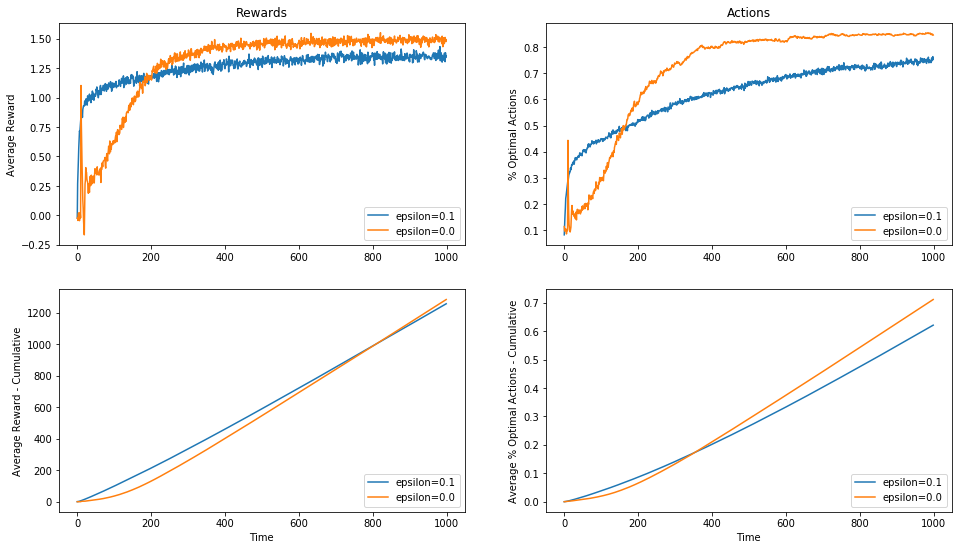

In [6]:
# Problem setup
k = 10 # Number of actions, i.e., how many arms the bandit has.
total_runs  = 2000 # Number of randomly generated k-armed bandit problems .
T = 1000 # Total of time steps per instance.

# Variance parameter for rewards sampling.
rewards_var = 1

# Step-size parameter
alpha = 0.1

# Returns for all simulations
returns = {} 

# Printing info
print('#General Info:')
print('k = {}, total_runs = {}, T = {}'.format(k, total_runs, T))
print('rewards_var = {}\n'.format(rewards_var))

## Realistic
# Epsilon-greedy action selection method. A value of 0.0 means greedy.
epsilon = 0.1
# Initial values for Q
Qini = np.zeros(k)

start = time.time()
print('Running Realistic...'.format(epsilon))
t_Q, t_R, t_opt_A = simulate(k, total_runs, rewards_var, T, epsilon, Qini, alpha)
returns['epsilon='+str(epsilon)] = {'Q':t_Q, 
                                    'R':t_R, 
                                    'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)

## Optimistic
# Epsilon-greedy action selection method. A value of 0.0 means greedy.
epsilon = 0.0
# Initial values for Q
Qini = np.tile(5.0, k)

start = time.time()
print('Running Optimistic...'.format(epsilon))
t_Q, t_R, t_opt_A = simulate(k, total_runs, rewards_var, T, epsilon, Qini, alpha)
returns['epsilon='+str(epsilon)] = {'Q':t_Q, 
                                    'R':t_R, 
                                    'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)

# Visual
plot_results(returns)